In [1]:
#IMPORT NECESSARY LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
#load the dataset
df = pd.read_csv('labels.csv')
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./images\N1.xml,1093,1396,645,727
1,./images\N100.xml,134,301,312,350
2,./images\N101.xml,31,139,128,161
3,./images\N102.xml,164,316,216,243
4,./images\N103.xml,813,1067,665,724


In [3]:
import xml.etree.ElementTree as xet

In [4]:
filename = df['filepath'][0]
filename

'./images\\N1.xml'

In [5]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./images',filename_image)
    return filepath_image

In [6]:
getFilename(filename)

'./images\\N1.jpeg'

In [7]:
image_path = list(df['filepath'].apply(getFilename))
image_path 

['./images\\N1.jpeg',
 './images\\N100.jpeg',
 './images\\N101.jpeg',
 './images\\N102.jpeg',
 './images\\N103.jpeg',
 './images\\N104.jpeg',
 './images\\N105.jpeg',
 './images\\N106.jpeg',
 './images\\N107.jpeg',
 './images\\N108.jpeg',
 './images\\N109.jpeg',
 './images\\N11.jpeg',
 './images\\N110.jpeg',
 './images\\N111.jpeg',
 './images\\N112.jpeg',
 './images\\N113.jpeg',
 './images\\N114.jpeg',
 './images\\N116.jpeg',
 './images\\N117.jpeg',
 './images\\N118.jpeg',
 './images\\N119.jpeg',
 './images\\N12.jpeg',
 './images\\N120.jpeg',
 './images\\N121.jpeg',
 './images\\N122.jpeg',
 './images\\N123.jpeg',
 './images\\N124.jpeg',
 './images\\N126.jpeg',
 './images\\N127.jpeg',
 './images\\N128.jpeg',
 './images\\N129.jpeg',
 './images\\N130.jpeg',
 './images\\N131.jpeg',
 './images\\N132.jpeg',
 './images\\N133.jpeg',
 './images\\N134.jpeg',
 './images\\N135.jpeg',
 './images\\N136.jpeg',
 './images\\N137.jpeg',
 './images\\N138.jpeg',
 './images\\N139.jpeg',
 './images\\N14.jpeg

#### verify image and output

In [8]:
file_path = image_path[0]
file_path 

'./images\\N1.jpeg'

In [9]:
img = cv2.imread(file_path)

cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
cv2.rectangle(img,(1093,645),(1396,727),(0,255,0),3)
cv2.namedWindow('example',cv2.WINDOW_NORMAL)
cv2.imshow('example',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Data Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
labels = df.iloc[:,1:].values

In [47]:
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [16]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [17]:
X.shape,y.shape

((225, 224, 224, 3), (225, 4))

In [18]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

### Deep Learning Model

In [19]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [20]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable=False

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 24s 0us/step


In [22]:
# complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### model training

In [23]:
from tensorflow.keras.callbacks import TensorBoard

In [24]:
tfb = TensorBoard('object_detection')

In [25]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=100,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/100
18/18 [==============================] - 84s 3s/step - loss: 0.1653 - val_loss: 0.1520
Epoch 2/100
18/18 [==============================] - 55s 3s/step - loss: 0.1597 - val_loss: 0.1464
Epoch 3/100
18/18 [==============================] - 57s 3s/step - loss: 0.1588 - val_loss: 0.1545
Epoch 4/100
18/18 [==============================] - 55s 3s/step - loss: 0.1599 - val_loss: 0.1467
Epoch 5/100
18/18 [==============================] - 54s 3s/step - loss: 0.1625 - val_loss: 0.1556
Epoch 6/100
18/18 [==============================] - 59s 3s/step - loss: 0.1611 - val_loss: 0.1530
Epoch 7/100
18/18 [==============================] - 54s 3s/step - loss: 0.1574 - val_loss: 0.1461
Epoch 8/100
18/18 [==============================] - 57s 3s/step - loss: 0.1588 - val_loss: 0.1484
Epoch 9/100
18/18 [==============================] - 55s 3s/step - loss: 0.1557 - val_loss: 0.1468
Epoch 10/100
18/18 [==============================] - 56s 3s/step - loss: 0.1582 - val_loss: 0.1760
Epoch 11/

In [27]:
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=200,
                    validation_data=(x_test,y_test),callbacks=[tfb],initial_epoch=101)

Epoch 102/200
18/18 [==============================] - 40s 2s/step - loss: 2.1098e-04 - val_loss: 0.0068
Epoch 103/200
18/18 [==============================] - 40s 2s/step - loss: 1.7650e-04 - val_loss: 0.0066
Epoch 104/200
18/18 [==============================] - 40s 2s/step - loss: 2.5557e-04 - val_loss: 0.0073
Epoch 105/200
18/18 [==============================] - 40s 2s/step - loss: 3.4667e-04 - val_loss: 0.0060
Epoch 106/200
18/18 [==============================] - 40s 2s/step - loss: 3.3367e-04 - val_loss: 0.0072
Epoch 107/200
18/18 [==============================] - 40s 2s/step - loss: 4.5396e-04 - val_loss: 0.0073
Epoch 108/200
18/18 [==============================] - 40s 2s/step - loss: 4.4901e-04 - val_loss: 0.0065
Epoch 109/200
18/18 [==============================] - 40s 2s/step - loss: 3.6501e-04 - val_loss: 0.0066
Epoch 110/200
18/18 [==============================] - 40s 2s/step - loss: 3.5768e-04 - val_loss: 0.0067
Epoch 111/200
18/18 [==============================] - 

In [28]:
model.save('./models/object_detection.h5')

In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [31]:
model = tf.keras.models.load_model('./models/object_detection.h5')
print('model loaded sucessfully')

model loaded sucessfully


In [32]:
path = r'C:\Users\Eswar\Desktop\Project\2_Train_Object_Detection_model\images\N1.jpeg'
image = load_img(path) 
image = np.array(image,dtype=np.uint8) 
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # convert into array and get the normalized output

In [33]:
# size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 1080
Width of the image = 1920


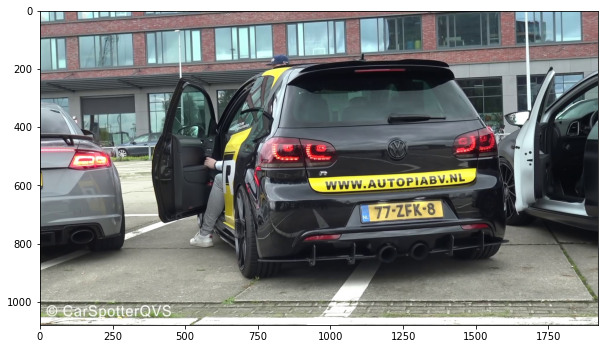

In [34]:
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [35]:
image_arr_224.shape

(224, 224, 3)

In [36]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [37]:
# make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 9s 9s/step


array([[0.55810344, 0.73634547, 0.59709984, 0.6679473 ]], dtype=float32)

In [38]:

denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[1071.55860901, 1413.78330231,  644.86782789,  721.38307571]])

In [39]:
coords = coords.astype(np.int32)
coords

array([[1071, 1413,  644,  721]])

(1071, 644) (1413, 721)


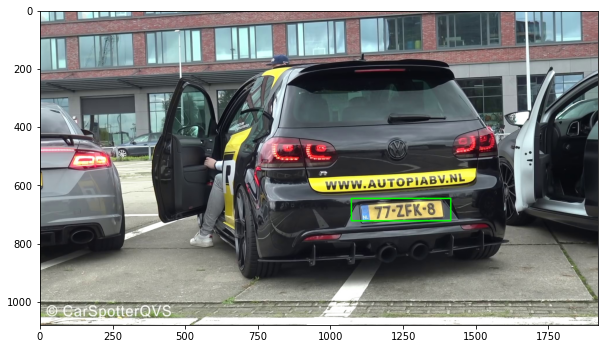

In [40]:
# draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)
cv2.rectangle(image,pt1,pt2,(0,255,0),3)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [41]:
# create pipeline
path = r'C:\Users\Eswar\Desktop\Project\2_Train_Object_Detection_model\images\N1.jpeg'
def object_detection(path):
    # read image
    image = load_img(path) 
    image = np.array(image,dtype=np.uint8) 
    image1 = load_img(path,target_size=(224,224))
    # data preprocessing
    image_arr_224 = img_to_array(image1)/255.0  
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    # make predictions
    coords = model.predict(test_arr)
    # denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    # draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

1/1 [==============================] - 0s 408ms/step
(1071, 644) (1413, 721)


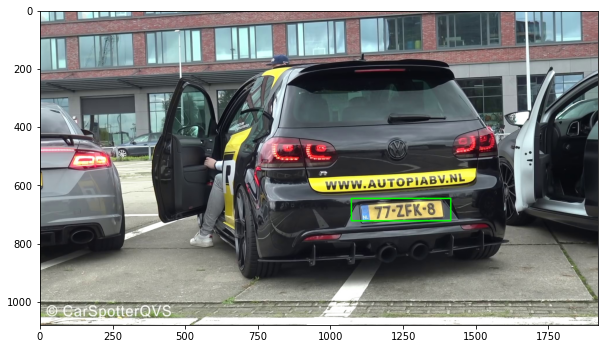

In [42]:
path = r'C:\Users\Eswar\Desktop\Project\2_Train_Object_Detection_model\images\N1.jpeg'
image, cods = object_detection(path)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

## Optical Character Recognition - OCR

In [43]:

import pytesseract as pt

1/1 [==============================] - 0s 402ms/step
(1071, 644) (1413, 721)


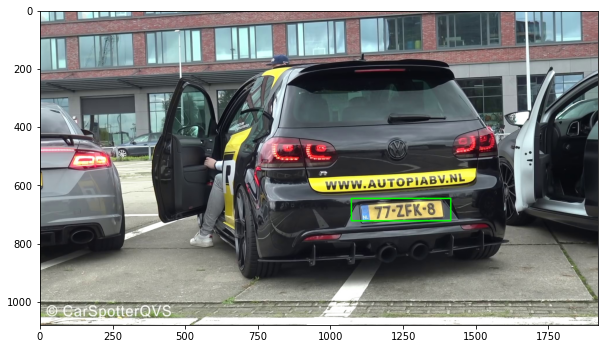

In [44]:
path = r'C:\Users\Eswar\Desktop\Project\2_Train_Object_Detection_model\images\N1.jpeg'
image, cods = object_detection(path)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [45]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]

In [ ]:
# extract text from image
text = pt.image_to_string(roi)
print(text)